In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Getting to know the data

In [248]:
df = pd.read_csv('data.csv')

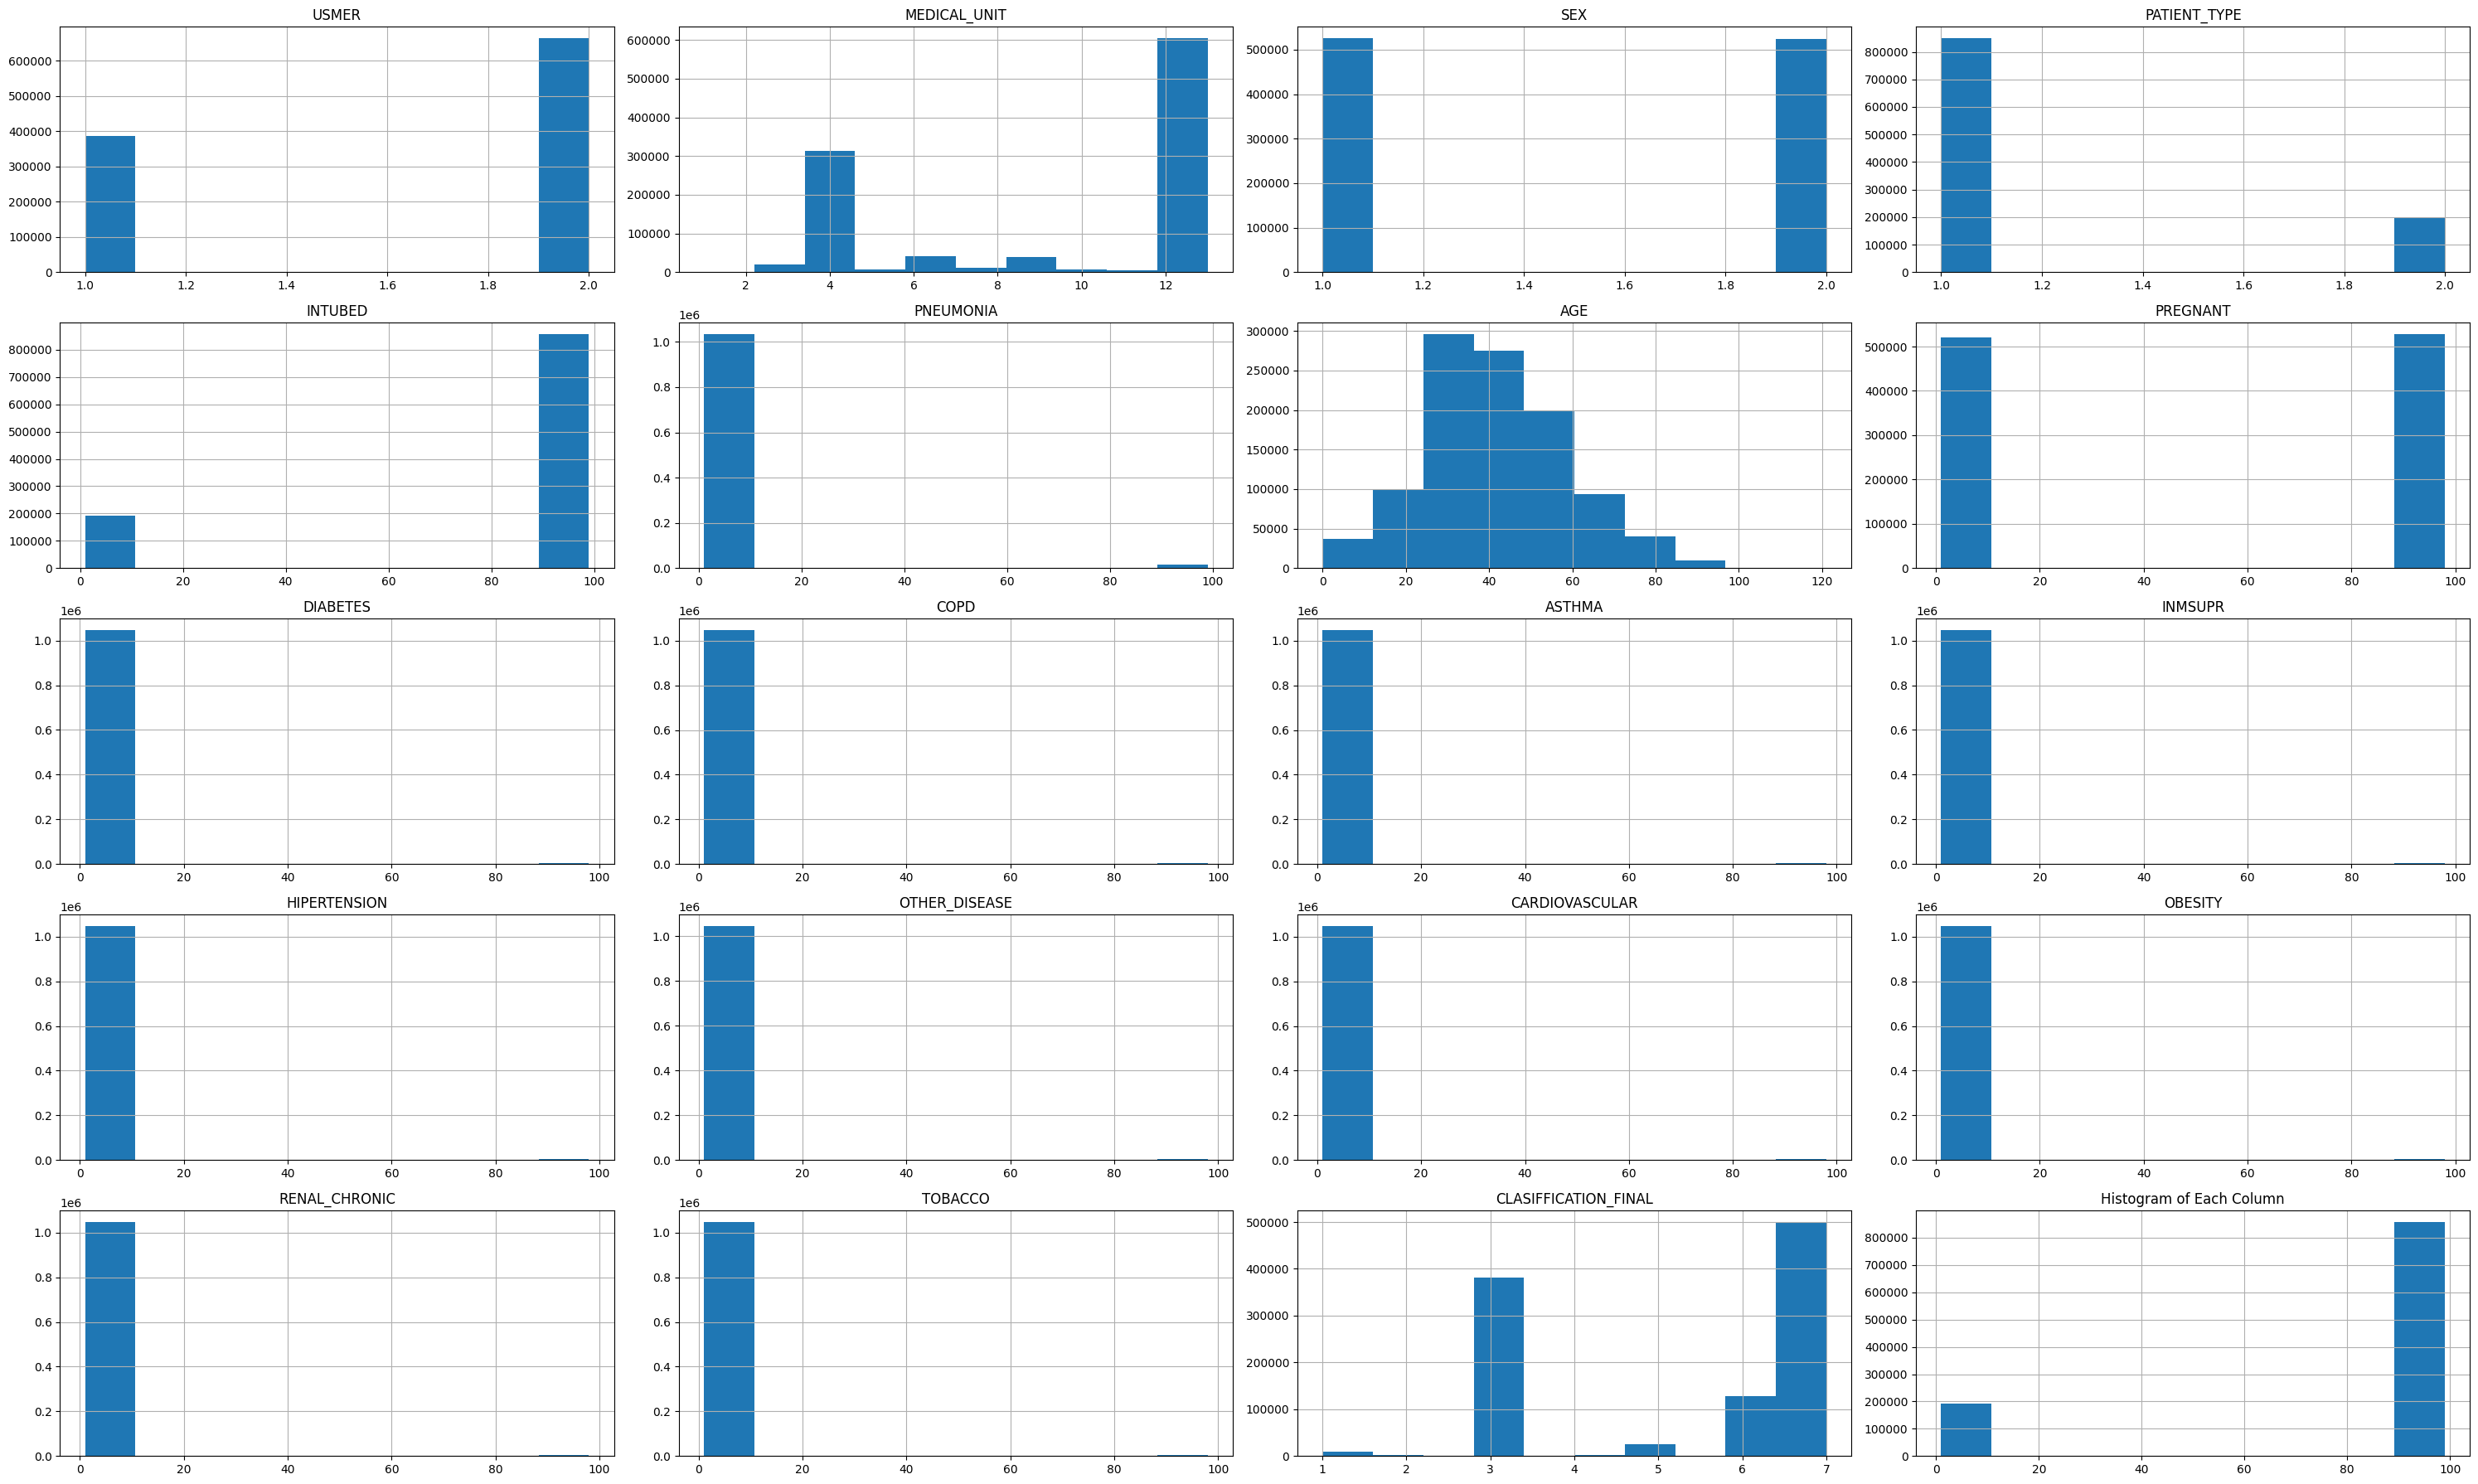

In [249]:
df.hist(bins=10, figsize=(30, 18))
plt.title('Histogram of Each Column')

plt.tight_layout()  
plt.show()

## Data Cleaning

#### Handling null values

##### Recognizing null values with a value in between 97 and 99 (kaggle documentation)

In [250]:
df['DATE_DIED'] = [2 if row =='9999-99-99' else 1 for row in df['DATE_DIED']]
df = df.rename(columns={'DATE_DIED':'DIED'})

df = df.where((df<97)|(df>99))

##### Dropping null columns and filling null values with mode

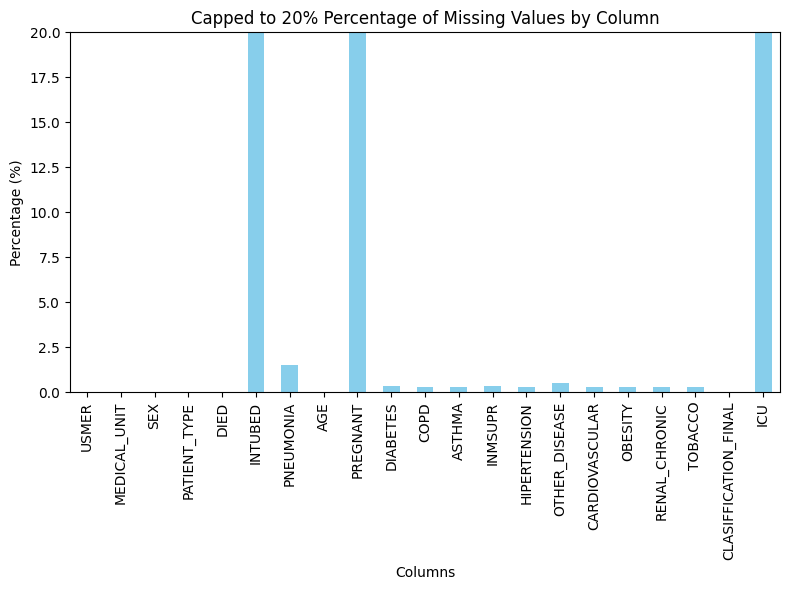

In [251]:
missing_percentage = df.isna().sum() / len(df) * 100
missing_percentage.plot(kind='bar', figsize=(8, 6), color='skyblue')

plt.title('Capped to 20% Percentage of Missing Values by Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')

plt.ylim(0, 20)
plt.tight_layout()
plt.show()

In [252]:
columns_to_drop = missing_percentage[missing_percentage > 50].index
df = df.drop(columns=columns_to_drop)

print('Columns to Drop:', columns_to_drop)

Columns to Drop: Index(['INTUBED', 'PREGNANT', 'ICU'], dtype='object')


In [253]:
columns_to_fill = df.columns[df.isna().sum() > 0]
for column in columns_to_fill:
    df[column] = df[column].fillna(df[column].mode()[0])

print(df.isna().sum()/len(df)*100)
cleaned_df = df

USMER                   0.0
MEDICAL_UNIT            0.0
SEX                     0.0
PATIENT_TYPE            0.0
DIED                    0.0
PNEUMONIA               0.0
AGE                     0.0
DIABETES                0.0
COPD                    0.0
ASTHMA                  0.0
INMSUPR                 0.0
HIPERTENSION            0.0
OTHER_DISEASE           0.0
CARDIOVASCULAR          0.0
OBESITY                 0.0
RENAL_CHRONIC           0.0
TOBACCO                 0.0
CLASIFFICATION_FINAL    0.0
dtype: float64


##### Removing remaining columns outlier

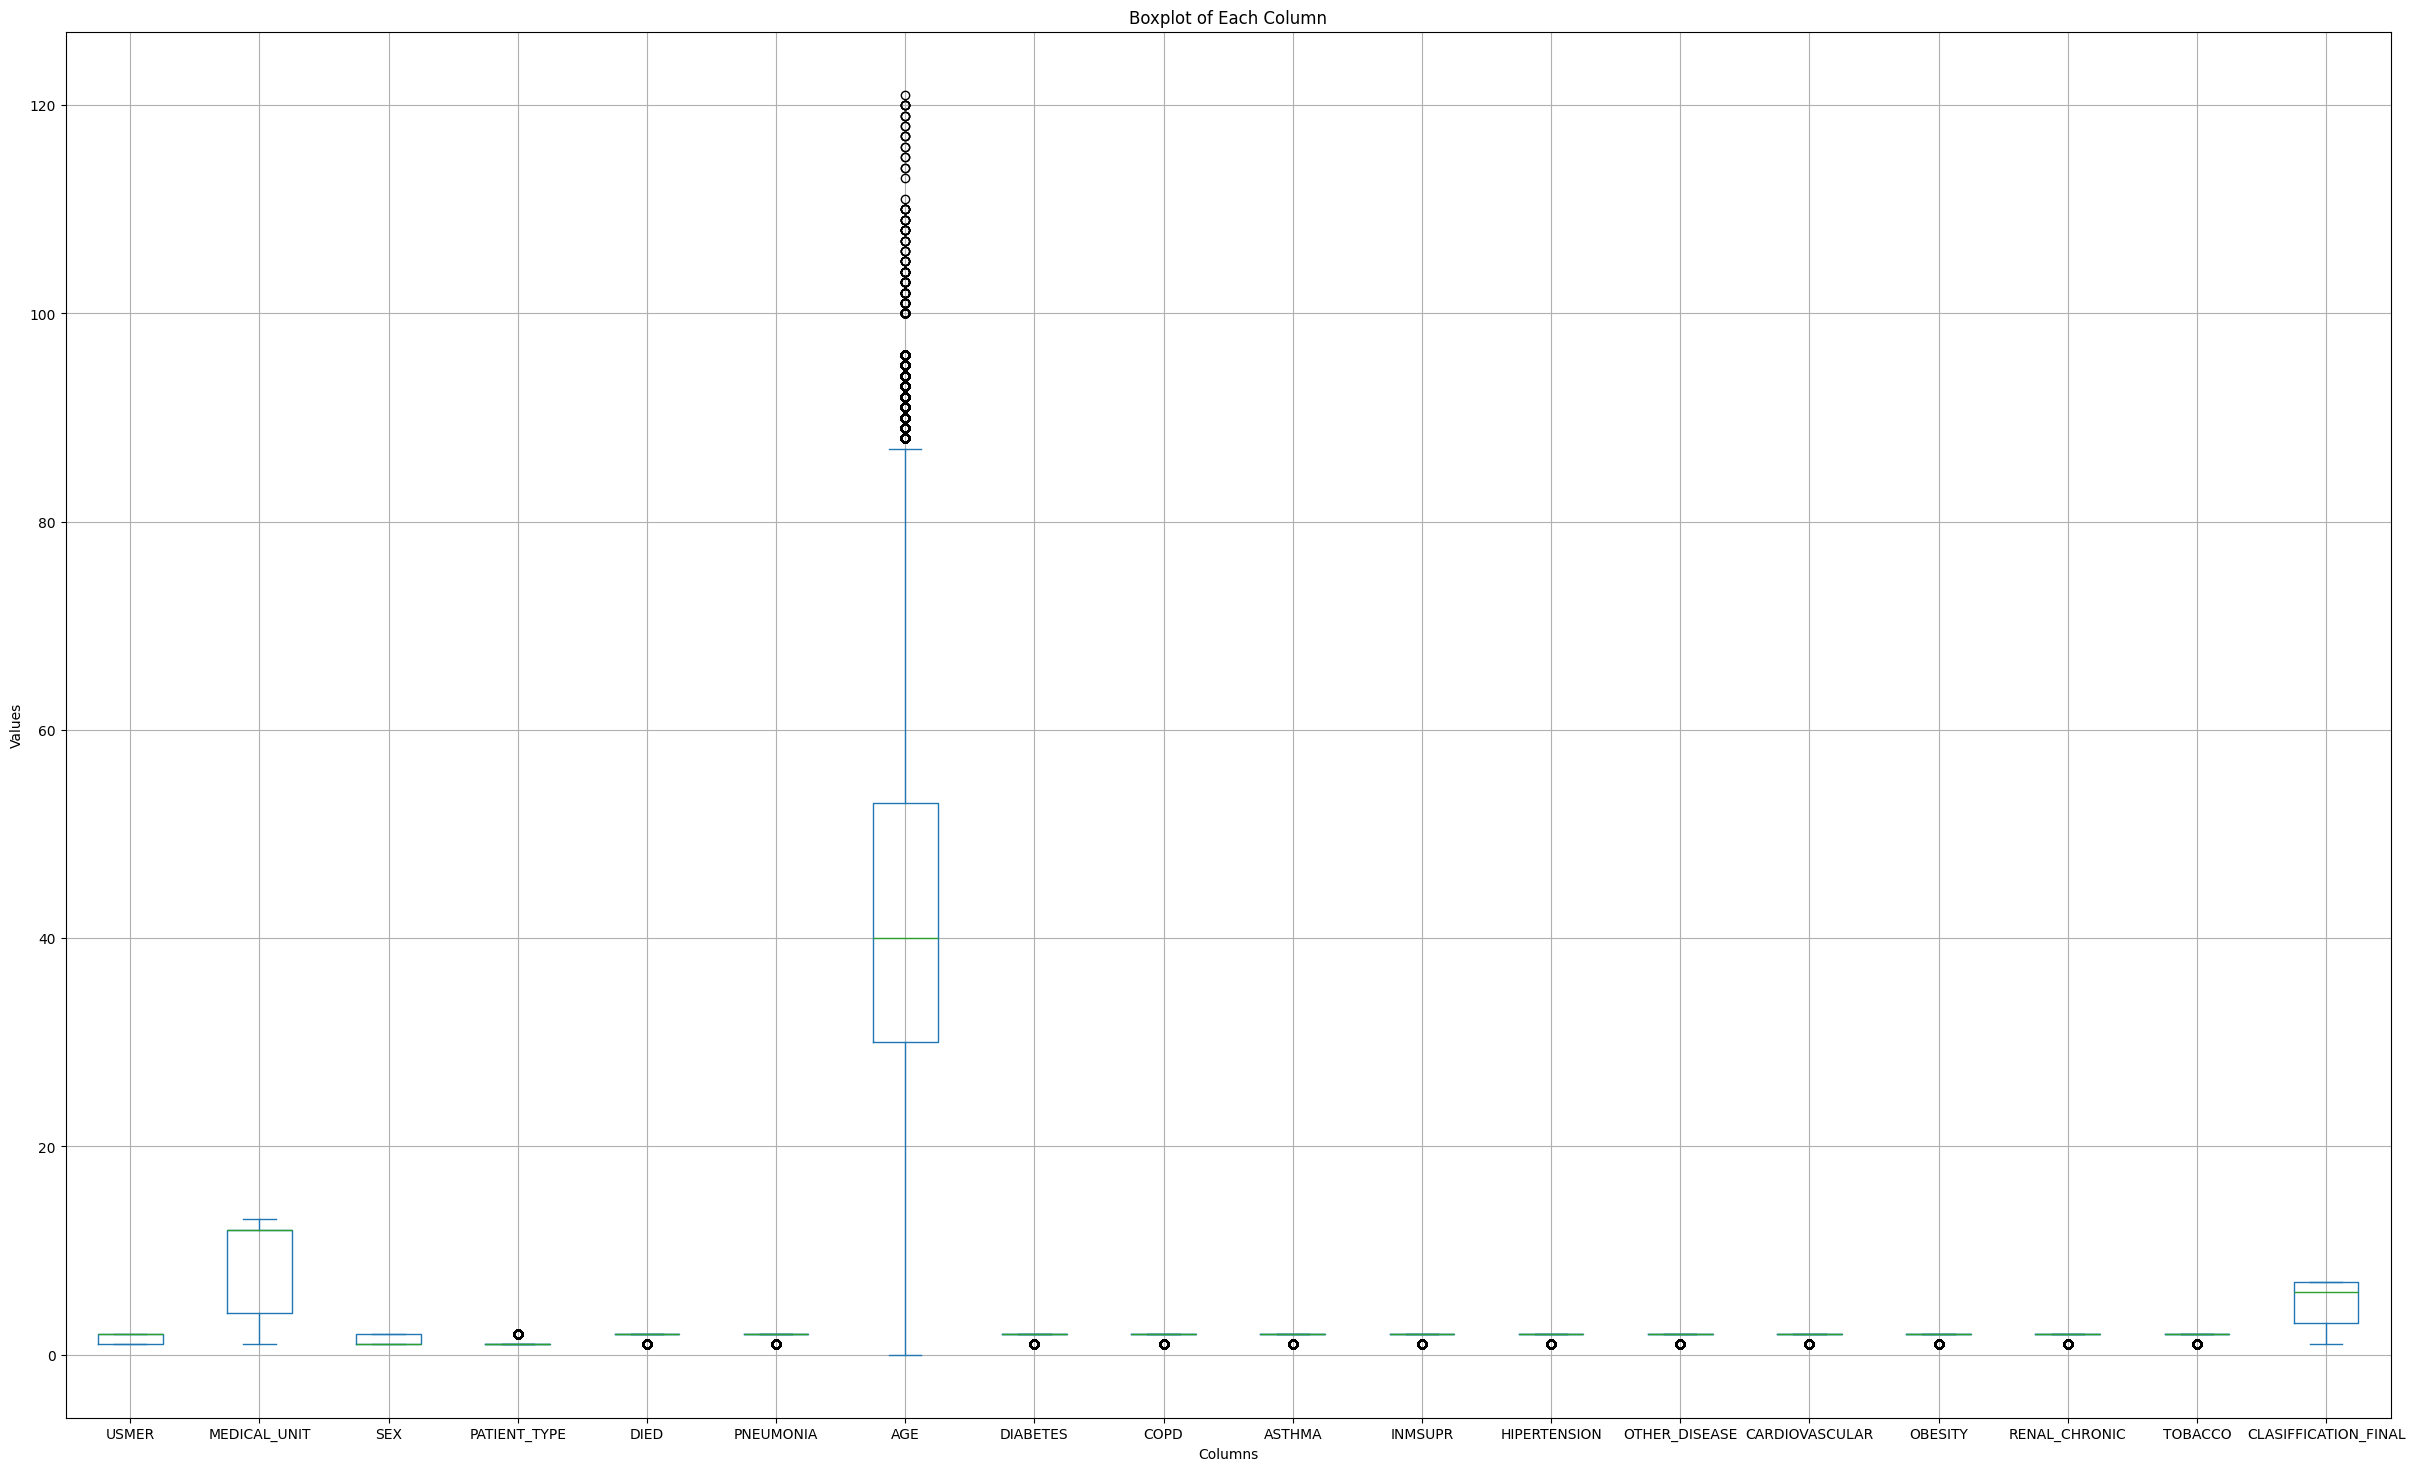

In [254]:
cleaned_df.plot.box(figsize=(30, 18), grid=True)

plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Boxplot of Each Column')

# Show the plot
plt.show()

In [255]:
age_iqr = cleaned_df['AGE'].quantile(0.75) - cleaned_df['AGE'].quantile(0.25)
age_outliers = cleaned_df['AGE'].quantile(0.75) + 1.5 * age_iqr 

cleaned_df = cleaned_df[cleaned_df['AGE'] < age_outliers]

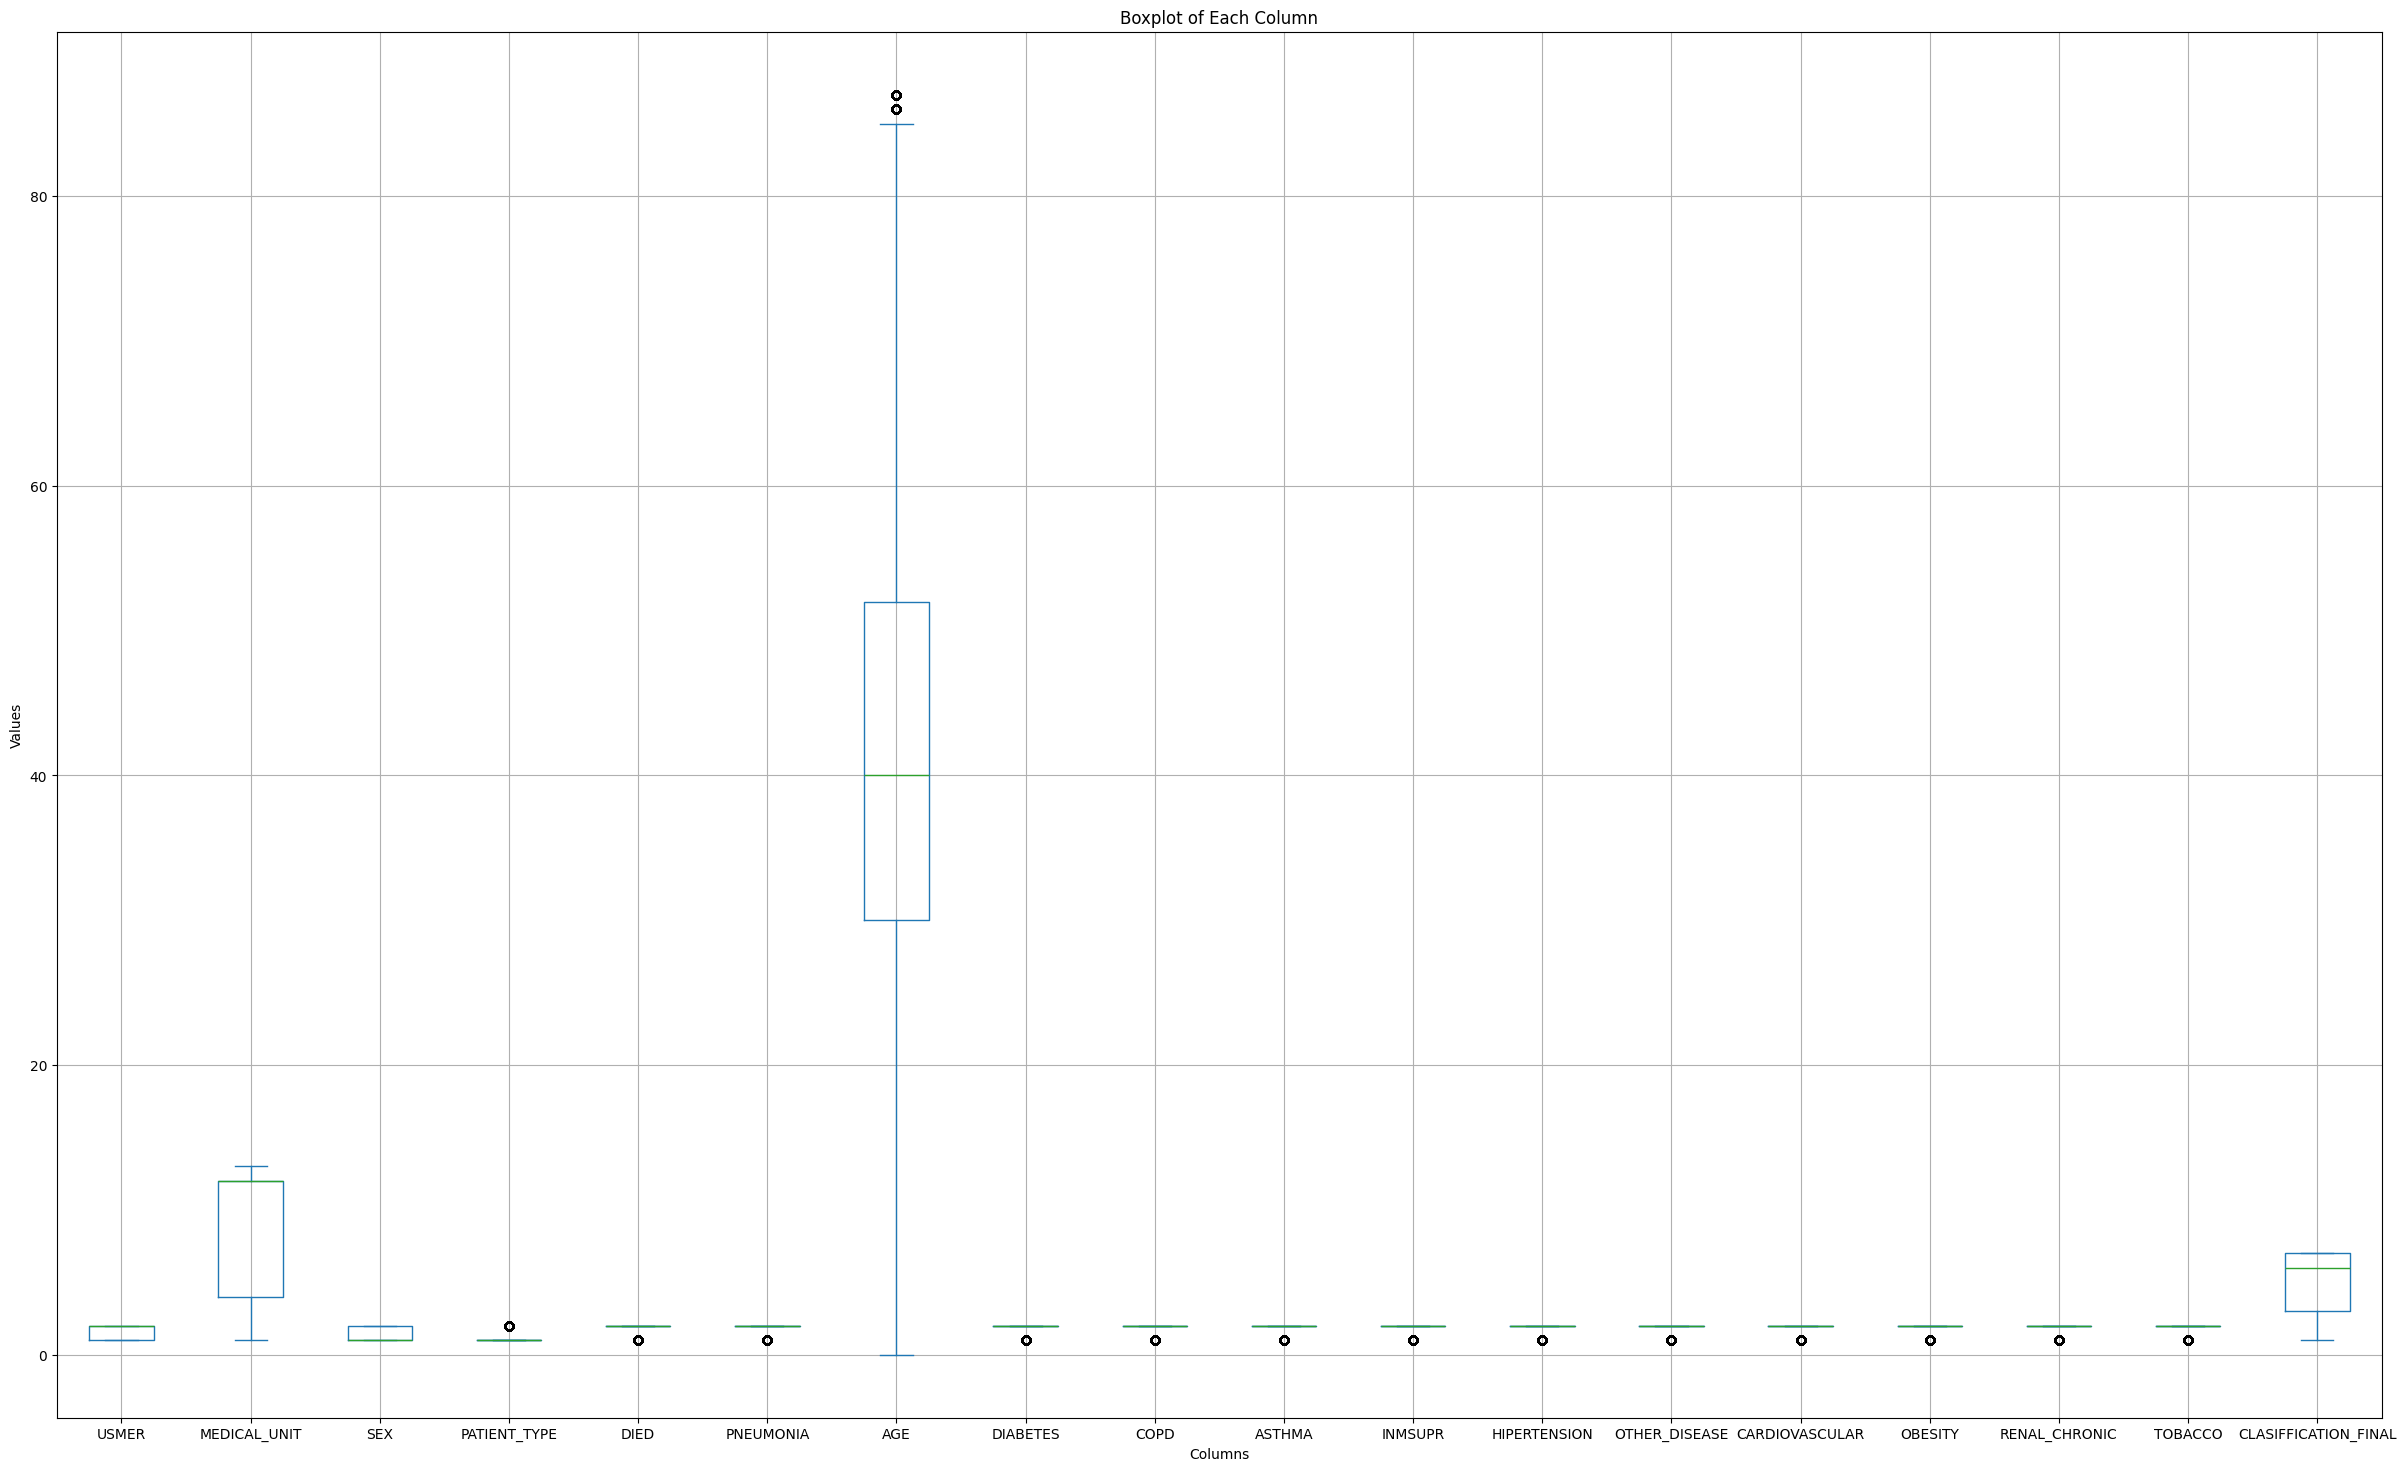

In [256]:
cleaned_df.plot.box(figsize=(30, 18), grid=True)

plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Boxplot of Each Column')

# Show the plot
plt.show()

## Data Reduction

#### Checking redundant feature

##### Using correlation matrix to display features correlation

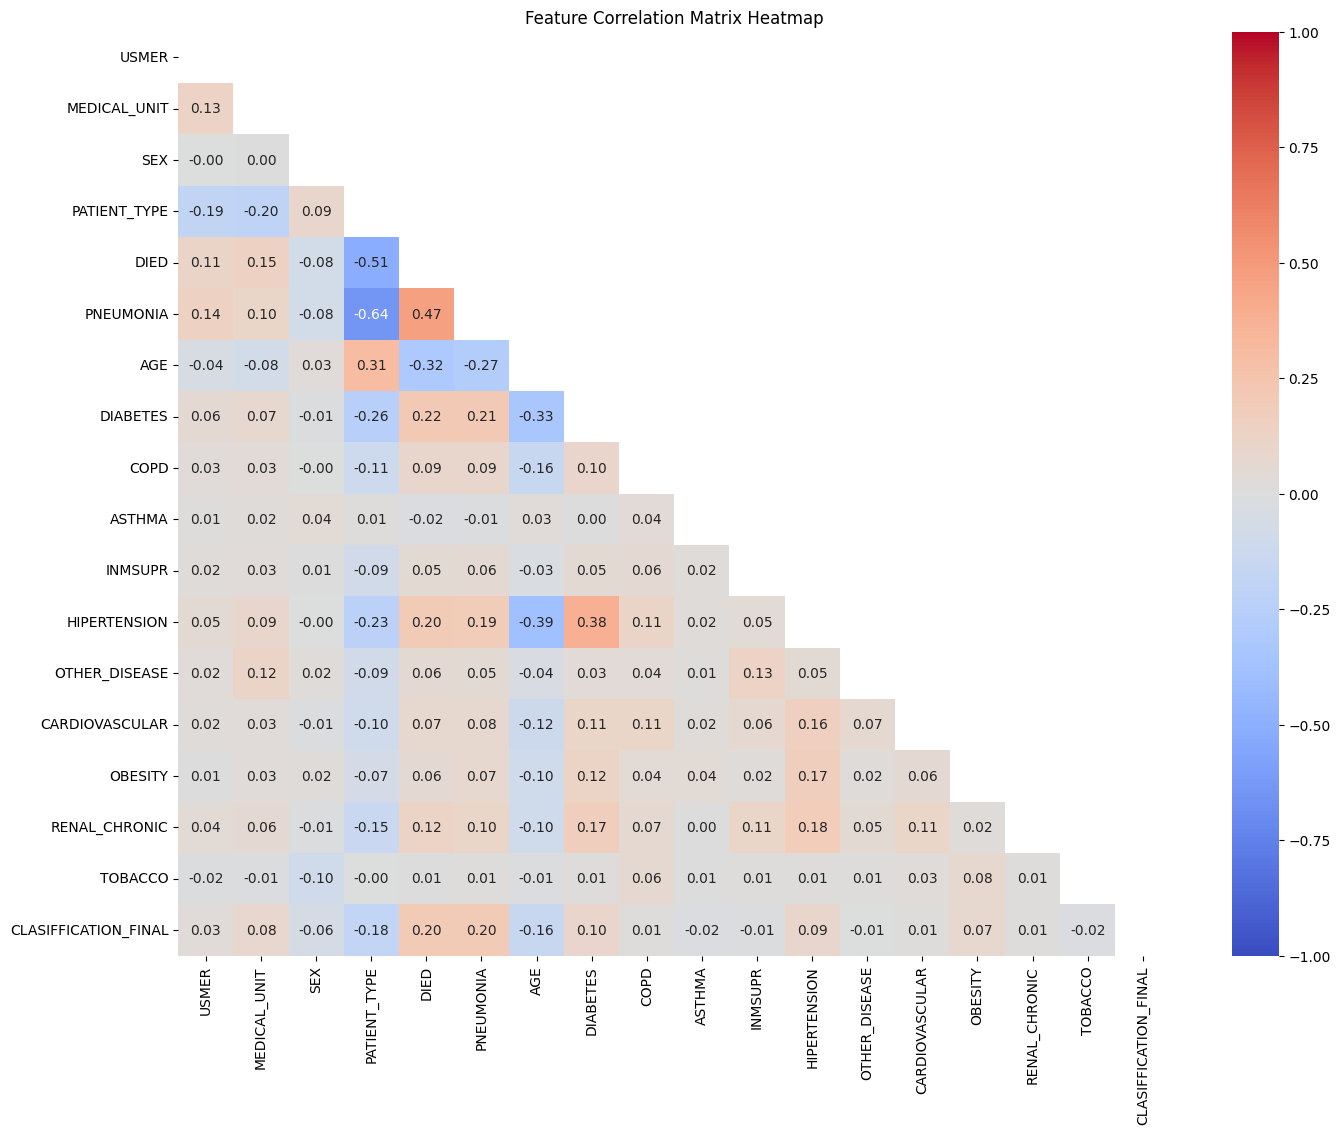

In [257]:
corr = cleaned_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))


plt.figure(figsize=(16, 12))
sns.heatmap(corr, mask=mask,annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Feature Correlation Matrix Heatmap')
plt.show()

#### Finding Principal Components

##### Determining the selected principal components

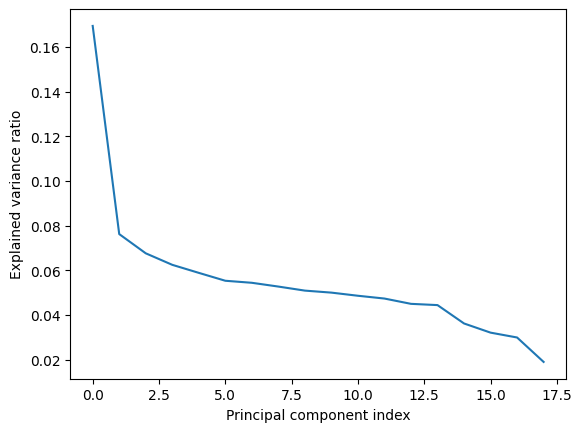

In [258]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cleaned_df)

pca = PCA()
pc = pca.fit_transform(X_scaled)

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

In [259]:
cumulative_variance_ration = np.cumsum(pca.explained_variance_ratio_)
threshold_index = np.argmax(cumulative_variance_ration > 0.8)

In [260]:
selected_pc = pc[:, :threshold_index] 
pc_df = pd.DataFrame(selected_pc, columns=[f'PC{i+1}' for i in range(threshold_index)])

pca_df = pd.concat([pc_df, cleaned_df], axis=1)

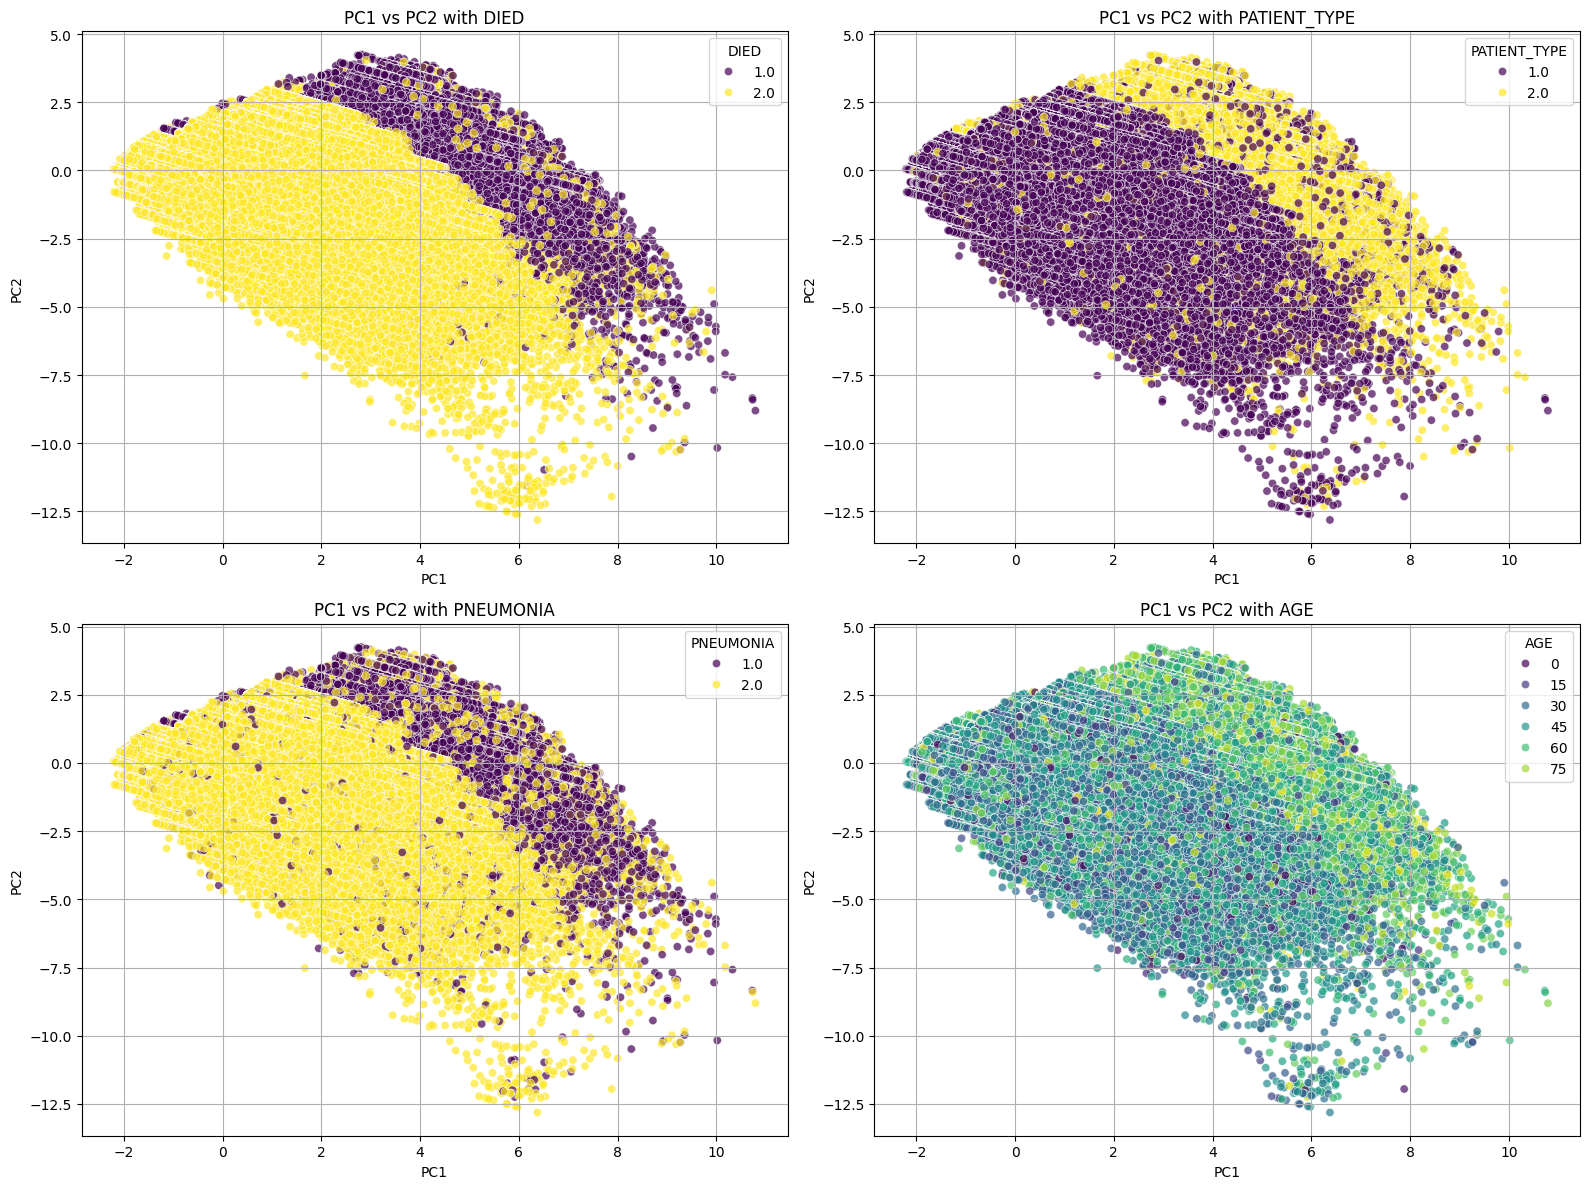

In [263]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

hue_columns = ['DIED', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE']
titles = ['PC1 vs PC2 with DIED', 'PC1 vs PC2 with PATIENT_TYPE', 'PC1 vs PC2 with PNEUMONIA', 'PC1 vs PC2 with AGE']

for ax, hue, title in zip(axes.flatten(), hue_columns, titles):
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=hue, palette='viridis', alpha=0.7, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [243]:
pc_df.to_csv('pca.csv', index=False)